This file visualizes the solutions found by $\Phi$-SO.

To reproduce the runs, you can use the the run.py and run.sh files found in each subfolder of 'runs/'. the run.py files are a copy, with modified hyperparameters, of the main SR_profile.py script, which is commented for ease of use.

In [45]:
import physo
import numpy as np
import sympy
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact,fixed
import ipywidgets as widgets
from sympy import lambdify
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 
from scipy.optimize import curve_fit
import os,glob

## Functions:

In [36]:
def load_model_data_radial(model_name,base_path):
    # Read mass
    rad = pd.read_csv(base_path + model_name + "/radial/0.0-200.0_radial_bin.dat", delimiter=" ", header=None)
    r = rad.to_numpy()  # shape: (N_rows, varying columns)
    
    # Read sigma_phi
    disp_phi = pd.read_csv(base_path + model_name +"/radial/0.0-200.0_disp_phi.dat", delimiter=" ", header=None)
    s_phi = disp_phi.to_numpy()

     # Read sigma_phi
    vel_phi = pd.read_csv(base_path + model_name +"/radial/0.0-200.0_vphi.dat", delimiter=" ", header=None)
    v_phi = vel_phi.to_numpy()
    
    # Read age
    age = pd.read_csv(base_path + model_name + "/age.dat",
                      sep=r"\s+", header=None).to_numpy().flatten()

    distance=  int(model_name.split('_')[3])

    mass = pd.read_csv(base_path + model_name + "/global/global_0.0-1.0_m_tot.dat", delimiter=" ", header=None)
    m_tot = mass.to_numpy() 
    number = pd.read_csv(base_path + model_name + "/global/global_0.0-1.0_N_tot.dat", delimiter=" ", header=None)
    N = number.to_numpy()

    # read global values
    data_global=np.loadtxt(base_path + model_name + "/global.30",skiprows=1)
    time=np.array(data_global[:,1]) #Myr
    rhm_=np.array(data_global[:,5]) #half-mass radius calcualted by Nbody6
    rj_=np.array(data_global[:,6])#jacobi radius
    rj=np.interp(age, time , rj_) #jacobi radius
    rh=np.interp(age, time , rhm_) #half mass radius
    
    return {
        "age": age,
        "mass": m_tot,
        "number": N,
        "half_mass_radius": rh,
        "jacobi_radius":rj,
        "distance":distance,
        "r": r,
        "disp_phi": s_phi,
        "v_phi": v_phi
    }

def get_data(good_models,age_target):
    data = []
    metadata = []
    for i,(model_name,model) in enumerate(good_models):
        ages = model['age']
        distance = model['distance']
        closest_age_idx = np.argmin(np.abs(ages-age_target))
        closest_age = ages[closest_age_idx]
        closest_r = model['r'][closest_age_idx]
        closest_v_phi = model['v_phi'][closest_age_idx]
        closest_disp = model['disp_phi'][closest_age_idx]
        closest_mass = model['mass'][closest_age_idx]
        initial_mass = model['mass'][0]
        initial_rj = model['jacobi_radius'][0]
        initial_rh = model['half_mass_radius'][0]
        closest_rj = model['jacobi_radius'][closest_age_idx]
        closest_rh = model['half_mass_radius'][closest_age_idx]
        initial_filling_factor = initial_rh/initial_rj
        closest_filling_factor = closest_rh/closest_rj
        closest_number = model['number'][closest_age_idx]
        initial_number = model['number'][0]
    
        mask = np.logical_and(np.isnan(closest_r) == False,np.isnan(closest_disp) == False)
        closest_r = closest_r[mask]
        closest_v_phi = closest_v_phi[mask]
        closest_disp = closest_disp[mask]
        
        metadata.append({
            'name':model_name,
            'age':closest_age,
            'distance':distance,
            'mass':closest_mass,
            'initial_mass':initial_mass,
            'number':closest_number,
            'initial_number':initial_number,
            'initial_filling_factor':initial_filling_factor,
            'closest_filling_factor':closest_filling_factor,
            'initial_rh':initial_rh,
            'initial_rj':initial_rj,
            'closest_rh':closest_rh,
            'closest_rj':closest_rj
        })
        data.append((closest_r,closest_v_phi,closest_disp))
    return data,metadata

## Constants:

In [3]:
#Path to simulations data
base_path = "../Nbody/"

models=[
'1.5M_A_R4_10',
'500k_A_R2_10',
'500k_A_R4_10',
'500k_C_R4_10',
'250k_A_R2_25',
'250k_A_R2_25_vlk',
'250k_A_R2_10',
'250k_A_R2_5',
'250k_A_R4_25',
'250k_A_R4_25_imf50',
'250k_A_R4_25_lk',
'250k_A_R4_25_retr',
'250k_A_R4_25_vlk',
'250k_A_R4_10',
'250k_A_R4_10_retr',
'250k_B_R4_25',
'250k_B_R4_25_lk',
'250k_C_R2_10',
'250k_C_R4_25',
'250k_C_R4_25_lk',
'250k_C_R4_10',
'250k_W6_R4_25',
'250k_W6_R4_25_retr',
'500k_A_R4_LC_part1',
'500k_A_R4_LC_part2']

## Load models:

In [4]:
# Filter out unwanted models (because they behave differently)
good_models = [models[i] for i in range(len(models))
               if 'retr' not in models[i] and
               'part' not in models[i] and
               models[i] != '250k_A_R2_5' and
               '1.5M' not in models[i]]

good_models = [(model,load_model_data_radial(model,base_path)) for model in good_models]

# Extrapolation of $\Phi$-SO fit:
In this section, we used $\Phi$-SO to get a formula describing the azimuthal velocity dispersion profile $\sigma_{v_\phi}(r)$, for different simulations, at age $\tau=12Gyr$. This simulation has both global constants shared by all simulations, and parameters that change from simulation to simulation.

We want to know if the expression and the constants found are only valid at 12 Gyr, or if they are more general and can be applied at any ages.

To do this, we take the earlier snapshots of each simulation, use the expression and global constants found, and fit for the remaining parameters. We measure the $R^2$ to see if the expression is able to match earlier data.

/var/folders/y5/0sfyq6j57glbwyqp2q417yvc0000gn/T/ipykernel_91154/1413544759.py:16: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(fit, data[j][0], data[j][2],maxfev=int(1e5))


Text(0, 0.5, '$R^2$')

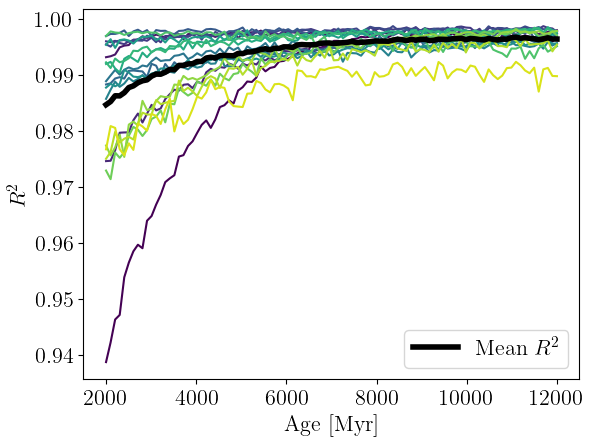

In [5]:
def fit(r,d,k0,tau):
    # The expression physo found at 12 Gyr, with the corresponding global constants
    T,rs,vc = (0.6325,7.0972,9.6255)
    return (d+rs/(np.exp(2*k0)+np.exp((r/tau+vc)/vc)))/T

ages = np.linspace(2_000,12_000,100)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

mean_r2 = np.zeros(len(ages))

for j in range(len(good_models)):
    rsquareds = np.zeros(len(ages))
    for i,age_target in enumerate(ages):
        data,metadata = get_data(good_models,age_target)
        popt, pcov = curve_fit(fit, data[j][0], data[j][2],maxfev=int(1e5))
        SSres = np.sum((fit(data[j][0],*popt)-data[j][2])**2)
        SStot = np.sum((data[j][2]-np.mean(data[j][2]))**2)
        rsquared = 1-SSres/SStot
        rsquareds[i] = rsquared
        mean_r2[i] += rsquared
    plt.plot(ages,rsquareds,c=plt.cm.viridis(j/len(data)))

plt.plot(ages,mean_r2/len(good_models),color='black',linewidth=4,label='Mean $R^2$')
plt.legend()
plt.xlabel('Age [Myr]')
plt.ylabel(r'$R^2$')

Even 10 Gyr before the data $\Phi$-SO saw, the expression is still valid, as the fits give a mean $R^2$ of 0.985 !

In [39]:
# Filter out unwanted models (because they behave differently)
good_models = [models[i] for i in range(len(models))
               if 'retr' not in models[i] and
               'part' not in models[i] and
               models[i] != '250k_A_R2_5' and
               '1.5M' not in models[i]]

good_models = [(model,load_model_data_radial(model,base_path)) for model in good_models]

# Analytical formula plots:

This is an interactive plot where you can visualize the different analytical formulae foundd by $\Phi$-SO against the data curves.

In [30]:
def update(t,show_formula,run):
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    colors = [color for i,color in enumerate(colors) if i != 7]
    color = colors[run]
    run = runs[run]
    run_name = run.split('/')[-2] + '/'
    if os.path.exists(run+"SR_curves_pareto.pkl") == False and run_name != 'run0disp/':
        return
    if run_name != 'run0disp/':
        pareto_expressions = physo.read_pareto_pkl(run+"SR_curves_pareto.pkl")
        best_expr = pareto_expressions[-1]
        sympy_expr = best_expr.get_infix_sympy(evaluate_consts=True)
        formula = best_expr.get_infix_latex()
        spe_csts = best_expr.free_consts.spe_values.numpy()[0]
        class_csts = best_expr.free_consts.class_values.numpy()[0]
    else:#Handle broken file manually for run0disp because the files emptied themselves??
        spe_csts = np.array([[ 0.4902594 ,  0.47117775,  0.43547079,  0.3244732 ,  0.32517087,
         0.3876851 ,  0.35145425,  0.3660788 ,  0.3501282 ,  0.3479377 ,
         0.39019789,  0.30245441,  0.30532916,  0.36323066,  0.28937445,
         0.28600342,  0.4289827 ,  0.4658425 ],
       [-0.84474949, -0.06744827, -0.01423688,  0.27704147,  0.31275657,
         0.36132908,  0.50426279,  0.40018236,  0.5237194 ,  0.52115033,
         0.5890927 ,  0.42428278,  0.4432822 ,  0.22951641,  0.46965338,
         0.50172138,  0.712761  ,  0.56212127],
       [ 1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ],
       [ 1.5811933 ,  1.75625751,  2.09221031,  1.37268521,  1.39789591,
         1.2806944 ,  1.4954003 ,  1.41518133,  1.49950745,  1.53548662,
         1.31467098,  1.60431165,  1.60821156,  1.39038358,  1.75799348,
         1.79034415,  1.34433334,  1.33770169]])
        class_csts = (0.6325,7.0972,9.6255)
        expr = sympy.sympify('(d+rs/(exp((r/tau+vc)/vc)+exp(2*k_0)))/T')
        T,rs,vc=sympy.symbols('T rs vc')
        expr = expr.subs([(T,class_csts[0]),(rs,class_csts[1]),(vc,class_csts[2])])
        sympy_expr = []
        d_symb,k0_symb,m_symb,tau_symb = sympy.symbols('d k_0 m tau')
        for d,k0,m,tau in zip(spe_csts[0],spe_csts[1],spe_csts[2],spe_csts[3]):
            sympy_expr.append(expr.subs([(d_symb,d),(k0_symb,k0),(m_symb,m),(tau_symb,tau)]))
        formula = r'\frac{d+\frac{r_s}{e^{2k_0}+e^{\frac{\frac{r}{\tau}+v_c}{v_c}}}}{T}'
    
    fig,ax = plt.subplots(figsize=(10,6))
    radii = np.linspace(1,150,1000)

    f = lambdify(sorted(sympy_expr[t].free_symbols,key=lambda x:str(x)),sympy_expr[t],'numpy')

    is_disp = 'disp' in run
    if is_disp:
        data_i = 2
        ys = (3.6,2.6,2.25)
    else:
        data_i = 1
        ys = (1.3,0.95,0.8)
    
    is_run_3 = run_name == 'run3/'#Flag to correct tau in formula + different parameters
    is_run_bis = run_name == 'runbis/'
    if is_run_3:
        formula = formula.replace('vc','v_h').replace('rs','r_h').replace('au','\\tau')
        
        tau = best_expr.free_consts.spe_values.numpy()[0][0][t]
        curve = f(tau,radii)
        
        tau = spe_csts[0][t]
        d = spe_csts[1][t]
        k0 = spe_csts[2][t]
        m = spe_csts[3][t]
        C = class_csts[0]
        M = class_csts[1]
        T = class_csts[2]
        rs = class_csts[3]
        vc = class_csts[4]
    elif is_run_bis:#Handle runbis which was not trained on the same simulations so we offset t by 1
        t_prime = min(t+1,len(spe_csts[1])-1)#The last simulation is missing in runbis so we cap t_prime to the max available index (lazy fix)
        f = lambdify(sorted(sympy_expr[t_prime].free_symbols,key=lambda x:str(x)),sympy_expr[t_prime],'numpy')
        formula = formula.replace('rs','r_s').replace('vc','v_c')
        curve = f(radii)
        
        d = 1
        k0 = spe_csts[1][t_prime]
        m = 1
        tau = 1
        T = 1
        rs = class_csts[1]
        vc = class_csts[2]
    elif run_name == 'run3disp/':#Handle run3disp which has different parameters
        curve = f(radii)
        ys = (3.6,2.6,2.25)

        d = spe_csts[0][t]
        k0 = spe_csts[1][t]
        m = 1
        tau = spe_csts[2][t]
        T = class_csts[0]
        rs = class_csts[1]
        vc = class_csts[2]
    else:
        curve = f(radii)

        d = spe_csts[0][t]
        k0 = spe_csts[1][t]
        m = spe_csts[2][t]
        tau = spe_csts[3][t]
        T = class_csts[0]
        rs = class_csts[1]
        vc = class_csts[2]
    
    #Plot selected curve + data
    plt.plot(radii,curve,c=color)
    plt.scatter(data[t][0],data[t][data_i],s=2,c=color)

    #Plot all other curves + data faded
    for i in range(len(data)):
        if is_run_bis and i == 0:
            continue
        f = lambdify(sorted(sympy_expr[i].free_symbols,key=lambda x:str(x)),sympy_expr[i],'numpy')
        if is_run_3:
            tau = best_expr.free_consts.spe_values.numpy()[0][0][i]
            curve = f(tau,radii)
        else:
            curve = f(radii)
        plt.plot(radii,curve,alpha=0.1,c='k')
        plt.scatter(data[i][0],data[i][data_i],alpha=0.1,c='k',s=2)
      
    if show_formula:#Display formula and constants
        plt.text(145,ys[0],r'$v_\phi = ' + formula + '$',fontsize=30,horizontalalignment='right')
        
        spe_consts = [[tau,r'\tau','s'],[d,'d','pc'],[k0,'k_0',''],[m,'m','kg']]
        if is_run_bis:
            spe_consts[2][1] = 'k_1'
        text = ''
        for i,spe_const in enumerate(spe_consts):
            if spe_const[0] != 1.0:
                if i > 0 and len(text) > 0:
                    text += ', '
                text += f'${spe_const[1]}=$' + f'{spe_const[0]:.4f} ' + spe_const[2]
        text = 'with ' + text
        plt.text(145,ys[1],
                 text,
                 color=color,
                 weight='bold',
                 horizontalalignment='right'
        )
        class_consts = [(T,'T','s'),(rs,'r_s','pc'),(vc,'v_c','km/s')]
        if is_run_3:
            class_consts += [(C,'C',''),(M,'M','kg')]
        text = ''
        for i,class_const in enumerate(class_consts):
            if class_const[0] != 1.0:
                if i > 0 and len(text) > 0:
                    text += ', '
                text += f'${class_const[1]}=$' + f'{class_const[0]:.4f} ' + class_const[2]
        if len(text) > 0:
            text = 'and ' + text
            plt.text(145,ys[2],text,horizontalalignment='right')
    
    if is_disp:
        plt.ylabel(r'$\sigma_{v_\phi}$ [km/s]')
        plt.ylim(0,5)
    else:
        plt.ylabel(r'$v_\phi$ [km/s]')
        plt.ylim(-1,2)
    plt.title('model ' + metadata[t]['name'])
    plt.xlabel('r [pc]')
    plt.xlim(0,150)
    plt.show()

run_folder = 'runs/'
runs = sorted(glob.glob(run_folder+'run*/'))
runs = [run for run in runs if run not in [run_folder+'run1/','runs/run2/']]#remove run1 and run2 as they were early tests with different parameters
runs += [run_folder+'run0disp/']

model_select = widgets.Dropdown(
    options=[(meta['name'],i) for i,meta in enumerate(metadata)],
    value=0,
    description='Model:'
)
run_select = widgets.Dropdown(
    options=[(run[:-1],i) for i,run in enumerate(runs)],
    value=0,
    description='Run:'
)
show_formula_button = widgets.Checkbox(
    value=False,
    description='Reveal equation',
    disabled=False,
    indent=True
)

interact(update,t=model_select,run=run_select,show_formula=show_formula_button)

interactive(children=(Dropdown(description='Model:', options=(('500k_A_R2_10', 0), ('500k_A_R4_10', 1), ('500k…

<function __main__.update(t, show_formula, run)>

# Using $\Phi$-SO to find proxies for unknown quantities:

In this example, we used $\Phi$-SO to get an analytical expression for the azimuthal velocity profiles of the different simulations, and are interested in the outer region slopes. There seems to be two categories of clusters, ones with a steep slope and ones with a shallow slope.

By plotting the data and the analytical solution for each cluster, colored by the cluster's distance to the Galactic centre, we see that the two categories are separated by distance. This means $\Phi$-SO was able to pick on the differences in the cluster properties from the profiles, even though we only provided the profile data.

<>:32: SyntaxWarning: invalid escape sequence '\p'
<>:32: SyntaxWarning: invalid escape sequence '\p'
/var/folders/y5/0sfyq6j57glbwyqp2q417yvc0000gn/T/ipykernel_91154/2280890372.py:32: SyntaxWarning: invalid escape sequence '\p'
  plt.text(140,ys[0],'$v_\phi = ' + formula + '$',fontsize=30,horizontalalignment='right')


(0.0, 150.0)

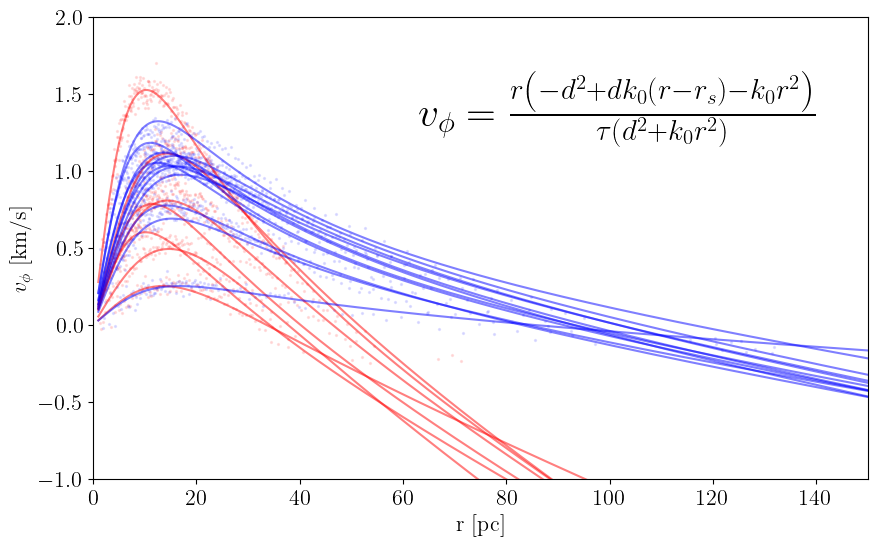

In [40]:
run = 'runs/run3/'

age_target = 12_000
data,metadata = get_data(good_models,age_target)

pareto_expressions = physo.read_pareto_pkl(run+"/SR_curves_pareto.pkl")
best_expr = pareto_expressions[-1]
sympy_expr = best_expr.get_infix_sympy(evaluate_consts=True)
formula = best_expr.get_infix_latex()
spe_csts = best_expr.free_consts.spe_values.numpy()[0]
class_csts = best_expr.free_consts.class_values.numpy()[0]

fig,ax = plt.subplots(figsize=(10,6))
radii = np.linspace(1,150,1000)

data_i = 1
ys = (1.3,0.95,0.8)

formula = formula.replace('vc','v_h').replace('rs','r_h').replace('au','\\tau')

for i in range(len(data)):
    f = lambdify(sorted(sympy_expr[i].free_symbols,key=lambda x:str(x)),sympy_expr[i],'numpy')
    tau = best_expr.free_consts.spe_values.numpy()[0][0][i]
    curve = f(tau,radii)
    
    distance = metadata[i]['distance']
    color = ['r','b'][[10,25].index(distance)]
    
    plt.plot(radii,curve,alpha=0.5,c=color)
    sc=plt.scatter(data[i][0],data[i][data_i],alpha=0.1,c=color,s=2)

plt.text(140,ys[0],'$v_\phi = ' + formula + '$',fontsize=30,horizontalalignment='right')

plt.ylabel(r'$v_\phi$ [km/s]')
plt.xlabel('r [pc]')
plt.ylim(-1,2)
plt.xlim(0,150)

Here, we plot the parameters that $\Phi$-SO found for each cluster, and compare them to the cluster properties, to see if we have any correlation (jut visually).

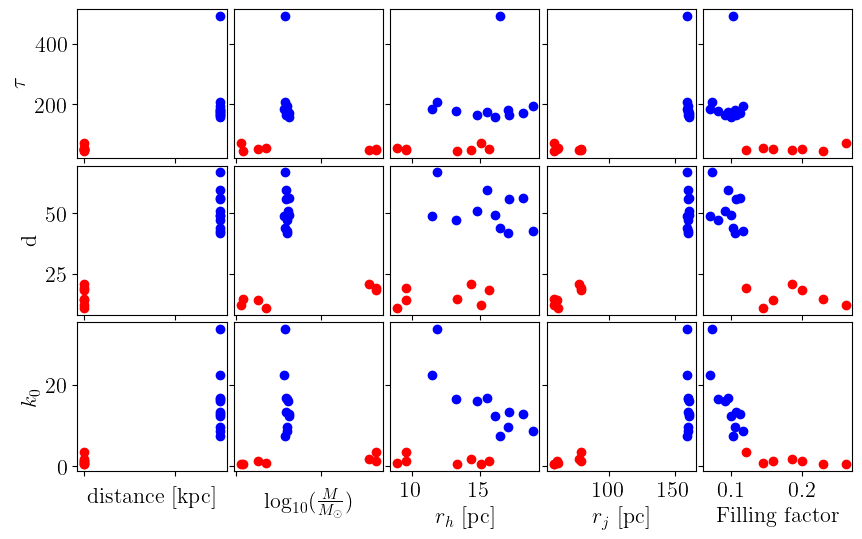

In [41]:
fig,ax = plt.subplots(3,5,figsize=(10,6),sharey=False)

csts_names,csts = sorted(
    [best_expr.free_consts.library.spe_free_constants_names,
     best_expr.free_consts.spe_values.numpy()
    ],
    key=lambda x:str(x[0])
)
csts_names = [name.replace('au',r'$\tau$') for name in csts_names]
csts = csts[0]

for i in range(len(metadata)):
    params = [csts[j][i] for j in range(4)]
    distance = metadata[i]['distance']
    mass = metadata[i]['mass']
    rh = metadata[i]['closest_rh']
    rj = metadata[i]['closest_rj']
    ff = metadata[i]['closest_filling_factor']
    
    for j,param in enumerate(params[:-1]):
        color = ['r','b'][[10,25].index(distance)]
        ax[j,0].scatter(distance,param,c=color)
        ax[j,1].scatter(np.log10(mass),param,c=color)
        ax[j,2].scatter(rh,param,c=color)
        ax[j,3].scatter(rj,param,c=color)
        ax[j,4].scatter(ff,param,c=color)
        ax[j,0].set_ylabel(csts_names[j].replace('k0','$k_0$'))
        if j < len(params)-1:
            ax[j,0].set_xticklabels(())
            ax[j,1].set_xticklabels(())
        ax[j,1].set_yticklabels(())
        ax[j,2].set_yticklabels(())
        ax[j,3].set_yticklabels(())
        ax[j,4].set_yticklabels(())
    ax[-1,0].set_xlabel('distance [kpc]')
    ax[-1,1].set_xlabel(r'$\log_{10}(\frac{M}{M_\odot})$')
    ax[-1,2].set_xlabel(r'$r_h$ [pc]')
    ax[-1,3].set_xlabel(r'$r_j$ [pc]')
    ax[-1,4].set_xlabel('Filling factor')

fig.subplots_adjust(wspace=0.05,hspace=0.05)

It's not super clear from this plot, but we can also look at the correlations between the parameters themselves, maybe some parameters can be expressed as a function of others.

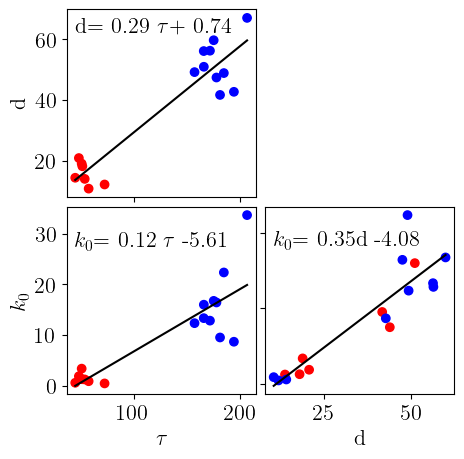

In [42]:
csts_names,csts = sorted(
    [best_expr.free_consts.library.spe_free_constants_names,
     best_expr.free_consts.spe_values.numpy()
    ],
    key=lambda x:str(x[0])
)
csts_names = [name.replace('au',r'$\tau$').replace('k0',r'$k_0$') for name in csts_names]
csts = csts[0]

fig,ax = plt.subplots(2,2,figsize=(5,5))

for i in range(3):
    for j in range(i):
        colors = []
        x = csts[j]
        y = csts[i]
        mask = x != np.max(x)
        x = x[mask]
        y = y[mask]
        for k in range(len(x)):
            distance = metadata[k]['distance']
            color = ['r','b'][[10,25].index(distance)]
            colors.append(color)
        ax[i-1,j].scatter(x,y,c=colors)
        if i == 2:
            ax[i-1,j].set_xlabel(csts_names[j])
        else:
            ax[i-1,j].set_xticklabels(())
        if j == 0:
            ax[i-1,j].set_ylabel(csts_names[i])
        else:
            ax[i-1,j].set_yticklabels(())

        popt,pcov = curve_fit(lambda x,a,b:a*x+b,x,y)
        xs = np.array((np.min(x),np.max(x)))
        ys = np.array((np.min(y),np.max(y)))
        ax[i-1,j].plot(xs,popt[0]*xs+popt[1],'k')

        ax[i-1,j].text(xs[0],ys.sum()/1.25,
                       csts_names[i] + '= {:.2f}'.format(popt[0]) + csts_names[j] +  ('+' if popt[1] > 0 else '') + ' {:.2f}'.format(popt[1])
        )

fig.delaxes(ax[0,1])
fig.subplots_adjust(wspace=0.05,hspace=0.05)

Just for testing, we fitted linear correlations between each parameter, so that we have $k_0=f_0(d)$ and $\tau=f_1(d)$. The real dependences are of course not linear, but we will make this approximation for demonstration purposes.

We are left with only one parameter, d, which is analogous to a length. On the interactive plot below, you can play with the value of d and try to reproduce the velocity profiles. Notice in the inset plot how, when you reproduce the red clusters, the d value is in the lower group of fitted d values, and going to the other category of clusters, you move towards the second group of fitted d values. There is no value inbetween the two categories.

This means $\Phi$-SO was able to build an analytical formula for the velocity profiles of clusters in which we can recognize a length parameter which is a proxy for the Galactic centre.

In [48]:
def update(d):
    def f(r,d):
        r_s = -86.31
        tau = (d-0.74)/0.29
        k0 = 0.35*d-4.08
        return r*(-d**2+d*k0*(r-r_s)-k0*r**2)/(tau*(d**2+k0*r**2))
    
    r = np.linspace(1,150,1000)

    fig,ax = plt.subplots(figsize=(10,6))
    
    ins = ax.inset_axes([0.75,0.55,0.2,0.4])
    ins.set_xticks(())
    
    plt.plot(r,f(r,d),'k',lw=3)
    for i in range(len(data)):
        distance = metadata[i]['distance']
        color = ['r','b'][[10,25].index(distance)]
        plt.scatter(data[i][0],data[i][data_i],alpha=0.1,c=color,s=2)
        _f = lambdify(sorted(sympy_expr[i].free_symbols,key=lambda x:str(x)),sympy_expr[i],'numpy')
        tau = best_expr.free_consts.spe_values.numpy()[0][0][i]
        curve = _f(tau,r)
        plt.plot(r,curve,alpha=0.5,c=color)
        ins.scatter(0,spe_csts[1][i],c=color,s=20)
    ins.scatter(0,d,c='k',s=40)
    plt.xlim(0,150)
    plt.ylim(-0.5,2)
    plt.xlabel('r [pc]')
    plt.ylabel(r'$v_\phi$ [km/s]')
    
d_widget = widgets.FloatSlider(
    value=20,
    min=10.0,
    max=70.0,
    step=0.1,
    description='d [pc]',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)

interact(update,d=d_widget)

interactive(children=(FloatSlider(value=20.0, continuous_update=False, description='d [pc]', max=70.0, min=10.…

<function __main__.update(d)>